## Домашнее задание  № 1 - анализ успеваемости студентов

### Задача
В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. \
Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента.\
 На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.

 ### Вам необходимо:
Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

### Описание данных
Для выполнения задания вам необходимы файлы train.csv, лекции.csv, вопросы.csv.

#### train.csv
- `row_id`: (int64) Идентификационный код строки.
- `timestamp`: (int64) время в миллисекундах между этим взаимодействием пользователя и завершением первого события от этого пользователя.
- `user_id`: (int32) Идентификационный код пользователя.
- `content_id`: (int16) Идентификационный код взаимодействия с пользователем
- `content_type_id`: (int8) 0, если событием был заданный пользователю вопрос, 1, если событием был просмотр лекции пользователем.
- `task_container_id`: (int16) Идентификационный код пакета вопросов или лекций. Например, пользователь может просмотреть три вопроса подряд, прежде чем увидит пояснения к любому из них. Все эти три параметра будут иметь общий - идентификатор task_container_id.
- `user_answer`: (int8) ответ пользователя на вопрос, если таковой имеется. Считайте -1 как null, для лекций.
- `answered_correctly`: (int8), если пользователь ответил правильно. Считайте -1 как null, для лекций.
- `prior_question_elapsed_time`: (float32) Среднее время в миллисекундах, которое потребовалось пользователю, чтобы ответить на каждый вопрос из предыдущего набора вопросов, игнорируя все лекции между ними. Значение null для первого набора вопросов или лекции пользователя. Обратите внимание, что это среднее время, затраченное пользователем на решение каждого вопроса из предыдущего пакета.
- `prior_question_had_explanation`: (bool) Независимо от того, видел ли пользователь объяснение и правильные ответы после ответа на предыдущий набор вопросов, игнорируя любые лекции между ними. Это значение используется в одном наборе вопросов и равно нулю для первого набора вопросов пользователя или лекции. Как правило, первые несколько вопросов, которые видит пользователь, были частью вступительного диагностического теста, на который он не получил никакой обратной связи.

### questions.csv: метаданные для вопросов, задаваемых пользователям.
- `question_id`: внешний ключ для столбца train/test content_id, если тип контента - question (0).
- `bundle_id`: код, для которого вопросы подаются вместе.
- `correct_answer`: ответ на вопрос. Можно сравнить со столбцом train user_answer, чтобы проверить, был ли пользователь прав.
- `part`: соответствующий раздел теста TOEIC.
- `tags`: один или несколько подробных кодов тегов для вопроса. Значение тегов приведено не будет, но этих кодов достаточно для объединения вопросов в группы.

### lectures.csv: метаданные для лекций, которые просматривают пользователи по мере их продвижения в обучении.
- `lecture_id`: внешний ключ для столбца train/test content_id, если тип контента - lecture (1).
- `part`: код категории верхнего уровня для лекции.
- `tag`: один из тегов, обозначающих лекцию. Значение тегов не будет указано, но этих кодов достаточно для объединения лекций в группы.
- `type_of`: краткое описание основной цели лекции.

In [16]:
import sys

In [17]:
import pandas as pd
import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [18]:
lectures = pd.read_csv('lectures.csv', sep=',')
questions = pd.read_csv('questions.csv', sep=',')
train = pd.read_csv('train.csv', sep=',')

MemoryError: Unable to allocate 512. KiB for an array with shape (65536,) and data type int64

In [ ]:
def inform(data):
    # Вывод информации о датасете
    print("Информация о датасете:")
    data.info()
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    # Вывод первых нескольких строк датасета
    print("Первые несколько строк датасета:")
    display(data.head())
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    #describe
    print('Описательная статистика:')
    display(data.describe())

    # Разделительная строка
    print("\n" + "="*50 + "\n")

    print('гистограмма численных показателей')
    data.hist(figsize=(9, 6), bins=50)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


Первые несколько строк датасета:


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False




Описательная статистика:


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,9.887879e+07
mean,5.061517e+07,7.703644e+09,1.076732e+09,5.219605e+03,1.935222e-02,9.040624e+02,1.376123e+00,6.251644e-01,2.542381e+04
std,2.922268e+07,1.159266e+10,6.197163e+08,3.866359e+03,1.377596e-01,1.358302e+03,1.192896e+00,5.225307e-01,1.994815e+04
min,0.000000e+00,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,2.530758e+07,5.243436e+08,5.408116e+08,2.063000e+03,0.000000e+00,1.040000e+02,0.000000e+00,0.000000e+00,1.600000e+04
50%,5.061517e+07,2.674234e+09,1.071781e+09,5.026000e+03,0.000000e+00,3.820000e+02,1.000000e+00,1.000000e+00,2.100000e+04
75%,7.592275e+07,9.924551e+09,1.615742e+09,7.425000e+03,0.000000e+00,1.094000e+03,3.000000e+00,1.000000e+00,2.966600e+04
max,1.012303e+08,8.742577e+10,2.147483e+09,3.273600e+04,1.000000e+00,9.999000e+03,3.000000e+00,1.000000e+00,3.000000e+05




гистограмма численных показателей


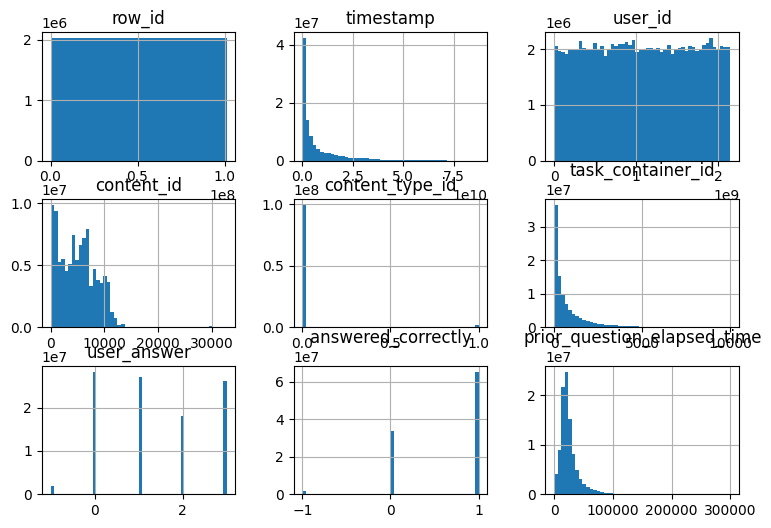

In [ ]:
inform(train)

In [ ]:
print(train['user_id'].nunique())
print(train['content_id'].nunique())

393656
13782


Как мы видим, в обучении задействовано ~400тыс учеников, для которых ротготовлено порядка 14 тыс вопросов\лекций

In [ ]:
train2 = pd.DataFrame()
train2['timestamp_datetime'] = pd.to_datetime(train['timestamp'], unit='ms')

print('минимум затраченного времени',train2['timestamp_datetime'].min())  # минимум (самое раннее время)
print('максимум затраченного на задачу времени',train2['timestamp_datetime'].max())  # максимум (самое позднее время)
print('диапазон времени проанализированно в сумме',train2['timestamp_datetime'].max() - train2['timestamp_datetime'].min())  # диапазон времени
print('диапазон времени в днях',(train2['timestamp_datetime'].max() - train2['timestamp_datetime'].min()).days)  # диапазон времени в днях

минимум затраченного времени 1970-01-01 00:00:00
максимум затраченного на задачу времени 1972-10-08 20:56:12.049000
диапазон времени проанализированно в сумме 1011 days 20:56:12.049000
диапазон времени в днях 1011


In [ ]:
#Выводимое количество правильных и неправильных ответов на вопросы.
print(train[train['content_type_id'] == 0]['answered_correctly'].value_counts())

#Выводимое среднее значение правильных ответов для каждого вопроса в столбце task_container_id, отсортированное по убыванию.
display(train[train['content_type_id'] == 0].groupby('task_container_id')['answered_correctly'].mean().sort_values(ascending=False))

#Выводимое наименьшее и наибольшее время для каждого вопроса в столбце task_container_id, разбитое на правильные и не правильные ответы..
display(train[train['content_type_id'] == 0].pivot_table(index='task_container_id', columns='answered_correctly', values='prior_question_elapsed_time', aggfunc=['min', 'max'])[['min', 'max']])

#Выводимое количество уникальных user_id для каждого значения столбца prior_question_had_explanation, разбитое на правильные и неправильные ответы.
display(train[train['content_type_id'] == 0].pivot_table(index='prior_question_had_explanation', columns='answered_correctly', values='user_id', aggfunc='nunique'))

#Выводимое количество уникальных вопросов в столбце task_container_id для правильных и неправильных ответов.
print(train[train['content_type_id'] == 0].groupby('answered_correctly')['task_container_id'].nunique())

answered_correctly
1    65244627
0    34026673
Name: count, dtype: int64


task_container_id
9872    0.837838
9393    0.831169
9811    0.821990
9741    0.819095
9729    0.817352
          ...   
11      0.453824
9       0.437195
2       0.435713
5       0.413369
6       0.314547
Name: answered_correctly, Length: 10000, dtype: float64

min               max          
answered_correctly       0       1         0         1
task_container_id                                     
0                      0.0     0.0  300000.0  300000.0
1                      0.0     0.0  300000.0  300000.0
2                      0.0     0.0  300000.0  300000.0
3                      0.0     0.0  300000.0  300000.0
4                      0.0     0.0  300000.0  300000.0
...                    ...     ...       ...       ...
9995                   0.0     0.0   48000.0   85000.0
9996                2000.0  2000.0   84750.0  136000.0
9997                1000.0  3333.0  300000.0  300000.0
9998                1500.0  3000.0   55000.0   72250.0
9999                4000.0  1750.0   57000.0  142000.0

[10000 rows x 4 columns]

answered_correctly                   0       1
prior_question_had_explanation                
False                           389386  388606
True                            312061  311893
answered_correctly
0    10000
1    10000
Name: task_container_id, dtype: int64


In [22]:
# Код ниже планировался для расчета по task_container_id - но жрёт слишком много памяти
#print(train[train['content_type_id'] == 0].groupby('task_container_id')['answered_correctly'].mean().apply(lambda x: [x > 0.8, x > 0.7 and x<0.8, x > 0.6 and x<0.7, x > 0.5 and x<0.6, x>0.4 and x<0.5]).sum())

Как мы видим, студенты ответили на 2/3 всех вопросов правильно\
Ни на один вопрос правильно не ответило свыше 84% сдававших, а на худшие вопрос - не менее 43% правильных ответов\
Как мы видим - практически на все вопросы некоторые люди отвечали мгновенно (начинали с них) - и максимум тратили на решение 300000мс\
Так же мы вимдим что количество людей, проверяющих ответы после решения и нет сравнительно равны\
Последнее демонстрирует что ни один из 10000 вопросов не был полностью решен или не решен никем

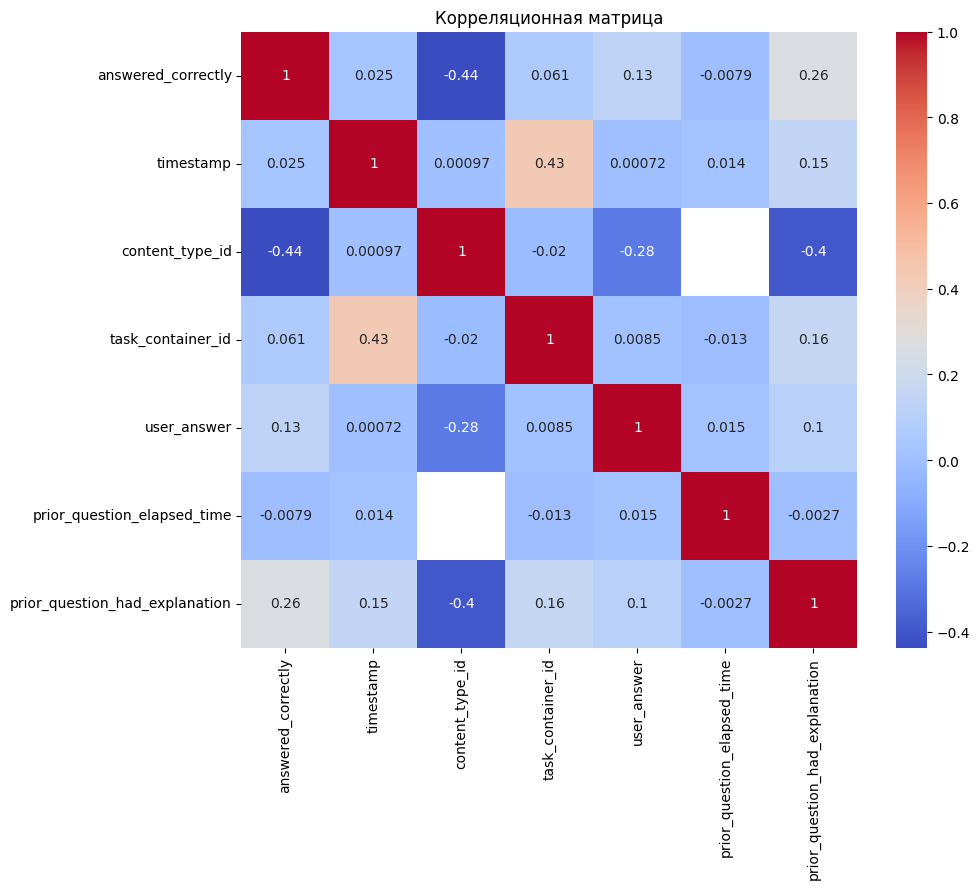

In [41]:
corr_matrix_tr = train.drop(['row_id', 'user_id', 'content_id'], axis=1).corr()

corr_matrix_tr = corr_matrix_tr.reindex(columns=['answered_correctly'] + [col for col in corr_matrix_tr.columns if col != 'answered_correctly'])
corr_matrix_tr = corr_matrix_tr.reindex(index=['answered_correctly'] + [col for col in corr_matrix_tr.index if col != 'answered_correctly'])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_tr, annot=True, cmap='coolwarm', square=True)
plt.title('Корреляционная матрица')
plt.show()

В корреляционной матрице выше мы видим, что корректность ответов (читай - успеваемость), зависит в первую очередь от собственно был ли это вопрос или лекция и минимально от того, какой это вопрос и смотрел ли он ответы

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


Первые несколько строк датасета:


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question




Описательная статистика:


,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000




гистограмма численных показателей


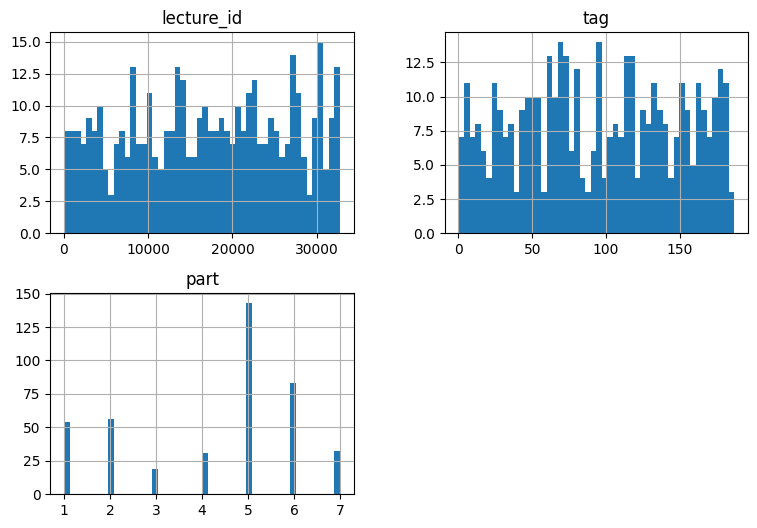

In [ ]:
inform(lectures)

In [26]:
print(lectures['part'].unique())
print(lectures['type_of'].unique())

[5 1 6 2 7 3 4]
['concept' 'solving question' 'intention' 'starter']


In [31]:
display(lectures.groupby(['part', 'type_of'])[['lecture_id', 'tag']].count().unstack())

lecture_id                                        tag            \
type_of    concept intention solving question starter concept intention   
part                                                                      
1             20.0       NaN             34.0     NaN    20.0       NaN   
2             18.0       7.0             31.0     NaN    18.0       7.0   
3              7.0       NaN             12.0     NaN     7.0       NaN   
4             19.0       NaN             12.0     NaN    19.0       NaN   
5             72.0       NaN             69.0     2.0    72.0       NaN   
6             63.0       NaN             19.0     1.0    63.0       NaN   
7             23.0       NaN              9.0     NaN    23.0       NaN   

                                  
type_of solving question starter  
part                              
1                   34.0     NaN  
2                   31.0     NaN  
3                   12.0     NaN  
4                   12.0     NaN  
5                   69.0     2.0  
6                   19.0     1.0  
7                    9.0     NaN

Как мы видим начальные лекции были только в 5 и 6 частях обучения, в то время как намерения рассматривались только во второй.\
По текущим данным видно, что большая часть занятий уходила на 5 и 6 часть, в то время как третей почти не уделялось времени\
При этом ответы на вопросы были по большей части в главе 6, и практически не отвечали на вопросы по главе 7.

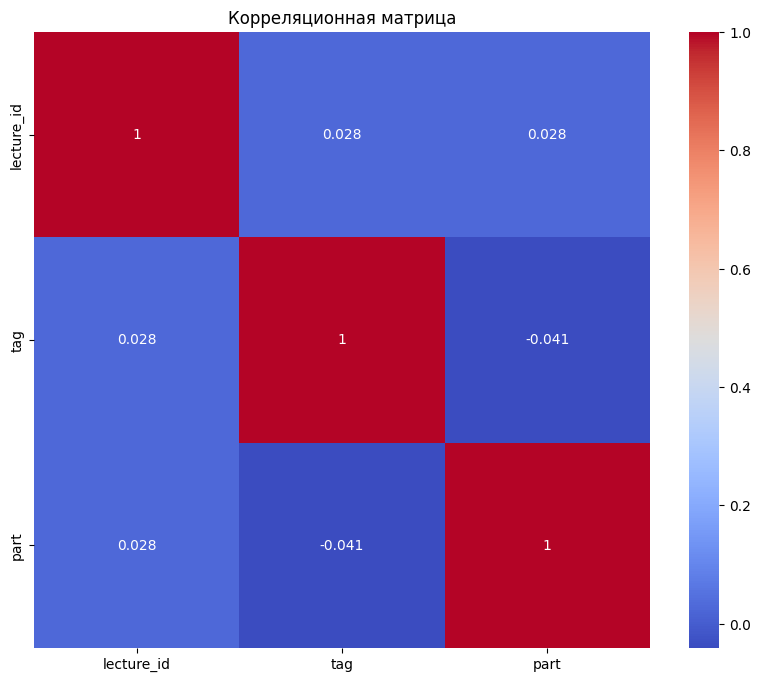

In [44]:
corr_matrix_l = lectures.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_l, annot=True, cmap='coolwarm', square=True)
plt.title('Корреляционная матрица')
plt.show()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


Первые несколько строк датасета:


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38




Описательная статистика:


,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000




гистограмма численных показателей


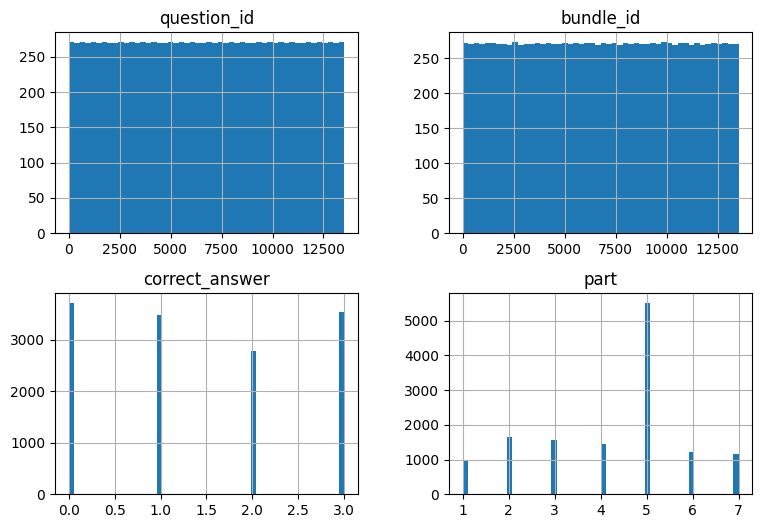

In [ ]:
inform(questions)

По данным выше мы видим, что рассмотренных вопросов было 13тыс, кроме этого в таблице с вариантами ответов и указанием на то, какие правильные данных нет.\
И в целом для рассмотрения характеристик/причин успеваемости студентов подобная конкретика избыточна - за исключением случаев когда мы рассматриваем задание и сложность его решения, но без специалиста соответствующей области и текста задания подобное скорее вредно, чем нет

### Итоговый вывод

На основе предоставленной информации можно сделать следующие выводы:

1. Студенты ответили правильно на 2/3 всех вопросов, что говорит о достаточно высоком уровне успеваемости.
2. Наибольшее количество вопросов, на которые студенты ответили правильно, находится в главе 6, что может говорить о том, что эта глава является наиболее важной или интересной для студентов.
3. Наименьшее количество вопросов, на которые студенты ответили правильно, находится в главе 7, что может говорить о том, что эта глава является наиболее сложной или менее интересной для студентов.
4. Студенты тратят наибольшее количество времени на решение вопросов в главе 5 и 6, что может говорить о том, что эти главы являются наиболее сложными или требуют больше времени для решения.
5. Корреляционная матрица показывает, что корректность ответов зависит в первую очередь от типа вопроса (лекция или вопрос) и минимально от того, какой это вопрос и смотрел ли он ответы.

Для повышения успеваемости в данном случае можно сделать следующие рекомендации:

1. Уделить больше внимания главе 7, которая является наиболее сложной для студентов.
2. Разработать дополнительные материалы для главы 7, которые помогут студентам лучше понять сложные темы.
3. Увеличить количество вопросов в главе 7, чтобы студенты могли лучше подготовиться к экзаменам.
4. Разработать систему обратной связи, которая позволит студентам получать более точную информацию о их успеваемости и понимании материала.
5. Провести анализ данных о времени, затраченном на решение вопросов, чтобы определить, какие вопросы являются наиболее сложными и требуют больше времени для решения.

Для более точной оценки успеваемости можно обработать следующие данные:

1. Данные о количестве попыток, которые студенты делают для решения вопросов, чтобы определить, какие вопросы являются наиболее сложными и требуют больше времени для решения.
2. Данные о типах вопросов, которые студенты решают правильно или неправильно, чтобы определить, какие типы вопросов являются наиболее сложными для студентов.
3. Данные о том, какие студенты решают вопросы правильно или неправильно, чтобы определить, какие студенты требуют больше поддержки и внимания.
4. Данные о том, как студенты используют дополнительные материалы, такие как видео-лекции или онлайн-ресурсы, чтобы определить, какие материалы являются наиболее эффективными для повышения успеваемости.